# Setup

## Environment Setup Instructions

You will first need to install the following in an Anaconda environment:
- Python == 3.7
- R == 3.6

This may be done using the following commands in your terminal:
```
conda create -n my-env python==3.7 r-essentials r-base
```

You should then activate your new environment:

```
conda activate my-env
```

Within the new environment, install the following Python and R packages using the commands below:

```
conda install -c conda-forge r-gam rpy2
pip install jupyterlab scanpy tzlocal
```

## Import Packages

In [2]:
import math, sys, os, time
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib import pyplot as plt, rc
import matplotlib.colors as mcolors

In [3]:
rc('font',**{'family':'serif','serif':['Arial']})

In [4]:
# Output parameters
dpi = 200

## Set Functions

#### The below functions set some global parameters and/or are required for analysis, and must be initialized prior to figure creation

In [5]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, "w")

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [6]:
from matplotlib import colors as mplcolors
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mplcolors.LinearSegmentedColormap('CustomMap', cdict)

In [7]:
from collections.abc import Iterable
from scipy.sparse import issparse

def compute_gene_trends(
    adata:sc.AnnData,
    genes:Iterable,
    trajectory:str, 
    n_jobs:int=-1,
    imputed_layer:str=None,
):
    """Function for computing gene expression trends along trajectory
    :param adata: AnnData object
    :param genes: genes for which to compute expression trends; index in var
    :param trajectory: column in obs which orders cells along trajectory  
    :param layer: layer of AnnData containing imputed gene expression values
    :return: Dictionary of gene expression trends and standard deviations for each branch
    """
    
    # Bin cells along trajectory
    bins = np.linspace(adata.obs[trajectory].min(), adata.obs[trajectory].max(), 1000)
    
    trends = pd.DataFrame(
        0.0, index=genes, columns=bins,
    )
    std = pd.DataFrame(
        0.0, index=genes, columns=bins,
    )
    
    # Cast imputed expression to dense matrix
    imp_exprs = adata[:, genes].X if not imputed_layer else adata[:, genes].layers[imputed_layer]
    if issparse(imp_exprs): imp_exprs = imp_exprs.todense()
    
    start = time.time()
    
    # Branch cells and weights
    res = Parallel(n_jobs=n_jobs)(
        delayed(_gam_fit_predict)(
            adata.obs[trajectory].values,
            imp_exprs.T[i],
            pred_x=bins,
        )
        for i, _ in enumerate(genes)
    )
    
    # Fill in the matrices
    for i, gene in enumerate(genes):
        trends.loc[gene, :] = res[i][0]
        std.loc[gene, :] = res[i][1]
    
    end = time.time()
    print(f"Time for processing: {(end - start) / 60} minutes")
          
    return trends, std

In [ ]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri, Formula
from rpy2.robjects.packages import importr
    
def _gam_fit_predict(x, y, weights=None, pred_x=None):

    pandas2ri.activate()

    # Weights
    if weights is None:
        weights = np.repeat(1.0, len(x))

    # Construct dataframe
    use_inds = np.where(weights > 0)[0]
    r_df = pandas2ri.py2rpy(
        pd.DataFrame(np.array([x, y]).T[use_inds, :], columns=["x", "y"])
    )

    # Fit the model
    rgam = importr("gam")
    model = rgam.gam(Formula("y~s(x)"), data=r_df, weights=pd.Series(weights[use_inds]))

    # Predictions
    if pred_x is None:
        pred_x = x
    y_pred = np.array(
        robjects.r.predict(
            model, newdata=pandas2ri.py2rpy(pd.DataFrame(pred_x, columns=["x"]))
        )
    )

    # Standard deviations
    p = np.array(
        robjects.r.predict(
            model, newdata=pandas2ri.py2rpy(pd.DataFrame(x[use_inds], columns=["x"]))
        )
    )
    n = len(use_inds)
    sigma = np.sqrt(((y[use_inds] - p) ** 2).sum() / (n - 2))
    stds = (
        np.sqrt(1 + 1 / n + (pred_x - np.mean(x)) ** 2 / ((x - np.mean(x)) ** 2).sum())
        * sigma
        / 2
    )

    return y_pred, stds

In [9]:
def cluster_gene_trends(trends, k=150, n_jobs=-1):
    """Function to cluster gene trends
    :param trends: Matrix of gene expression trends
    :param k: K for nearest neighbor construction
    :param n_jobs: Number of jobs for parallel processing
    :return: Clustering of gene trends
    """

    # Standardize the trends
    trends = pd.DataFrame(
        StandardScaler().fit_transform(trends.T).T,
        index=trends.index,
        columns=trends.columns,
    )

    # Cluster
    with HiddenPrints():
        clusters, _, _ = phenograph.cluster(trends, k=k, n_jobs=n_jobs)
    clusters = pd.Series(clusters, index=trends.index)
    return clusters

In [10]:
from sklearn.preprocessing import StandardScaler 

def plot_gene_trend_clusters(trends, clusters):
    """ Plot the gene trend clusters
    """

    # Standardize the trends
    trends = pd.DataFrame(
        StandardScaler().fit_transform(trends.T).T,
        index=trends.index,
        columns=trends.columns,
    )

    n_rows = int(np.ceil(len(set(clusters)) / 4))
    fig = plt.figure(figsize=[6 * 4, 2.75 * n_rows])
    for i, c in enumerate(set(clusters)):
        ax = fig.add_subplot(n_rows, 4, i + 1)
        means = trends.loc[clusters.index[clusters == c], :].mean()
        std = trends.loc[clusters.index[clusters == c], :].std()

        # Plot all trends
        for g in clusters.index[clusters == c]:
            ax.plot(
                means.index,
                np.ravel(trends.loc[g, :]),
                linewidth=0.5,
                color="lightgrey",
                alpha = 0.5,
            )

        # Mean
        ax.plot(means.index, np.ravel(means), color="#377eb8")
        ax.plot(
            means.index,
            np.ravel(means - std),
            linestyle="--",
            color="#377eb8",
            linewidth=0.75,
        )
        ax.plot(
            means.index,
            np.ravel(means + std),
            linestyle="--",
            color="#377eb8",
            linewidth=0.75,
        )
        ax.set_title("Cluster {}".format(c), fontsize=13, weight = "bold")
        ax.tick_params("both", length=2, width=1, which="major")
        ax.tick_params(axis="both", which="major", labelsize=8, direction="in")
        ax.set_xticklabels([])
        # ax.set_xticklabels( ax.get_xticklabels(), fontsize=8 )
        # ax.set_yticklabels( ax.get_yticklabels(), fontsize=8 )
    sns.despine()

In [11]:
def rank_gene_trend_clusters(trends, clusters):
    """ Rank the gene trend clusters according to correlation with mean
    """
    
    # Standardize the trends
    scaled_trends = pd.DataFrame(
        StandardScaler().fit_transform(trends.T).T,
        index=trends.index,
        columns=trends.columns,
    )
    # Find range of value for all trends
    trend_ranges = trends.max(axis=1) - trends.min(axis=1)
    
    ranked_trends = pd.DataFrame(
        index=trends.index,
        columns=['Cluster', 'Correlation', 'Range'],
    )
    
    for c in clusters.unique():
        cluster_trends = scaled_trends.loc[clusters.index[clusters==c]]
        corr = cluster_trends.corrwith(cluster_trends.mean(), axis=1).rename('Correlation')
        ptp = trend_ranges.loc[clusters.index[clusters==c]].rename('Range')
        ranked_trends.loc[cluster_trends.index, 'Cluster'] = c
        ranked_trends.loc[cluster_trends.index, ['Correlation', 'Range']] = pd.concat([corr, ptp], axis=1)
        
    return ranked_trends

In [12]:
def plot_ranked_gene_trends(trends, stds, rankings, n_genes=5, min_range=1.0):
    """ Plot the gene trends: each gene is plotted in a different panel
    :param: gene_trends: Results of the compute_marker_trends function
    """
    
    # Subset to rankings with at least minimum range
    rankings = rankings[rankings['Range']>=min_range]

    # Branches and genes
    clusters = np.sort(rankings['Cluster'].unique())
    colors = pd.Series(
        sns.color_palette("Set2", len(clusters)).as_hex(), index=clusters
    )

    # Set up figure
    n_rows = int(np.ceil(len(set(clusters)) / 4))
    fig = plt.figure(figsize=[6 * 4, 2.75 * n_rows])
    for i, (c, group) in enumerate(rankings.groupby('Cluster')):
        ax = fig.add_subplot(n_rows, 4, i + 1)
        genes = group.sort_values('Correlation', ascending = False).iloc[:n_genes]
        genes = genes.sort_values('Range', ascending = False).index.tolist()
        
        for gene in genes:
            ax.plot(
                trends.columns, trends.loc[gene, :], color=colors[c], label=gene
            )
            ax.set_xticks([0, 1])
            ax.fill_between(
                trends.columns,
                trends.loc[gene, :] - stds.loc[gene, :],
                trends.loc[gene, :] + stds.loc[gene, :],
                alpha=0.1,
                color=colors[c],
            )
        ax.set_title("Cluster {}".format(c), fontsize=13, weight = "bold")
        ax.legend()
        ax.tick_params("both", length=2, width=1, which="major")
        ax.tick_params(axis="both", which="major", labelsize=8, direction="in")

    sns.despine()

In [13]:
def plot_gene_trends(trends, stds, genes, palette, fig_size = 8, norm=True):
    """ Plot the gene trends: each gene is plotted in a different panel
    :param: gene_trends: Results of the compute_marker_trends function
    """
    standard_scaler = lambda x: (x - x.min())/(x.max() - x.min())

    if norm:
        # Standardize the trends
        trends = pd.DataFrame(
            StandardScaler().fit_transform(trends.T).T,
            index=trends.index,
            columns=standard_scaler(trends.columns),
        )
        stds.columns=trends.columns

    # Set up figure
    fig, ax = plt.subplots(1,1, figsize=[fig_size, fig_size*0.67])
    
    colors = sns.color_palette(palette, n_colors=len(genes))
    
    for gene, c in zip(genes, colors):
        ax.plot(
            trends.columns, trends.loc[gene, :], color=c, label=gene
        )
        ax.set_xticks([0, 1])
        ax.fill_between(
            trends.columns,
            trends.loc[gene, :] - stds.loc[gene, :],
            trends.loc[gene, :] + stds.loc[gene, :],
            alpha=0.1,
            color=c,
        )
    ax.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    sns.despine()
    return fig, ax

In [14]:
def format_ax(ax):
        
    ax.set_facecolor('white')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.grid(False)
    
    for side in ['bottom', 'left', 'top', 'right']:
        ax.spines[side].set_linewidth(0)

    # Reset x and y limits for square plotting
    xmin, xmax = ax.get_xlim()
    xrange = xmax - xmin
    xcenter = (xrange/2) + xmin

    ymin, ymax = ax.get_ylim()
    yrange = ymax - ymin
    ycenter = (yrange/2) + ymin

    axrange = max(xrange, yrange)/2

    xmin = xcenter - (axrange)
    xmax = xcenter + (axrange)
    ax.set_xlim(xmin, xmax)
        
    ymin = ycenter - (axrange)
    ymax = ycenter + (axrange)
    ax.set_ylim(ymin, ymax)
    
    ax.set_aspect('equal', adjustable = 'box')

In [15]:
def table_summary(
    adata, 
    key = "Sample ID",
    SEQC_stats = False,
):
    
    # Create a summary table of QC metrics for all samples
    metrics_summary = pd.DataFrame()

    metrics = {"original_total_counts": "Median Total Molecule Counts",
               "n_genes_by_counts" : "Median Library Complexity",
               "pct_counts_mito": "Median Mitochondrial RNA Fraction",
               "pct_counts_ribo": "Median Ribosomal RNA Fraction",
              }

    for val in pd.unique(adata.obs[key]):

        is_val = (adata.obs[key] == val)
        subset_adata = adata.obs.loc[is_val]

        metrics_summary.loc[val, "Total No. Cells"] = subset_adata.shape[0]

        for metric, name in metrics.items():

            metrics_summary.loc[val, name] = subset_adata[metric].median()
            
        if SEQC_stats & (key == "Sample ID"):
            
            stats = adata.uns[val]['SEQC_Summary']
            for column in stats:
                
                metrics_summary.loc[val, column] = stats[column].values[0]

    return metrics_summary

In [16]:
def get_ax(axes, n):
    
    if len(axes.shape) == 1:
        ax = axes[n]
    else:
        i = int(n/axes.shape[1])
        j = n%axes.shape[1]
        ax = axes[i,j]
    return ax

In [17]:
from typing import Union, List
from matplotlib.colors import to_rgba, LinearSegmentedColormap

def plot_adata(adata: sc.AnnData,
               category: Union[str, List[str]],
               rep: Union[str, List[str]] = 'X_umap',
               ncols: int = 5,
               palette: Union[str, List[str]] = 'plasma',
               layer: str = 'imputed',
               sorted: bool = False,
               vmin = None,
               vmax = None,
               titles = None,
               figsize = (6,6),
               space = 0.05,
               s = 4,
               colorbar = True,
              ) :

    # Plot all categories in column of obs
    if isinstance(category, str):
        try:
            categories = adata.obs[category].cat.categories
        except:
            categories = pd.unique(adata.obs[category])
        categorical = True

    # Plot all values in list in column of obs or var
    elif isinstance(category, list):
        categories = category
        categorical = False
    
    # Format figure for no. plots
    nrows = math.ceil(len(categories)/ncols)
    fig, axes = plt.subplots(nrows, ncols, 
                             figsize = (ncols*figsize[0], nrows*figsize[1]),
                             sharex = True,
                             sharey = True,
                            )
    
    plt.subplots_adjust(wspace = space, hspace = space)
    
    # Establish colormap
    if categorical:
        background = to_rgba("lightgray", 1.0)
        if type(palette) == str:
            base_cmap = sns.color_palette(palette, as_cmap = True)
            n_colors = len(categories)+1
            colors = [base_cmap(float(n/n_colors)) for n in range(0, n_colors)]
        else:
            colors = palette
            n_colors = len(colors)+1
        colors.insert(0, background)
        cmap = LinearSegmentedColormap.from_list("", colors, n_colors) 
    else:
        cmap = sns.color_palette(palette, as_cmap = True)
    
    # Plot Data
    for n, cat in enumerate(categories):
        
        cbar = not categorical and colorbar
        
        ax = get_ax(axes, n)

        found = True
        
        # Plot discrete column in obs
        if categorical:
            vals = adata.obs[category] == cat
            m = (n+1)/n_colors
            colors = vals.map(lambda x: cmap(float(x*m)))
        else:
            # Plot continuous column in obs
            if cat in adata.obs.columns.values:
                vals = adata.obs[cat]
                colors = vals
            # Plot gene in X
            elif cat in adata.var.index.values:
                if layer:
                    vals = adata[:, cat].layers[layer].T[0]
                else:
                    vals = adata[:, cat].X.T[0]
                if isinstance(vals, sp.sparse.spmatrix): vals = np.array(vals.todense().T)
                colors = vals.flatten()
            # Not Found
            else:
                cbar = False
                found = False
                vals = np.full((adata.shape[0]), 0)
                colors = np.full((adata.shape[0],4), to_rgba("lightgray", 1.0))


        if found:
            if sorted and categorical: 
                idx = np.argsort(vals)
            elif sorted: 
                idx = np.argsort(colors)
            else:
                idx = np.arange(colors.shape[0])
                np.random.shuffle(idx)

        x, y = adata.obsm[rep].T

        vmin_cat = vmin
        vmax_cat = vmax
        
        if cbar and isinstance(vmin, str): 
            qval = float(vmin.split('p')[1])
            vmin_cat = np.quantile(colors, q = qval/100)
        
        elif type(vmin) == list:
            vmin_cat = vmin_cat[n]
    
        if cbar and isinstance(vmax, str): 
            qval = float(vmax.split('p')[1])
            vmax_cat = np.quantile(colors, q = qval/100)   
        
        elif type(vmax) == list:
            vmax_cat = vmax_cat[n]

        ss = ax.scatter(x[idx], y[idx], c = colors[idx],
                        s = s,
                        cmap = cmap,
                        linewidth = 0,
                        vmin = vmin_cat,
                        vmax = vmax_cat,
                       )
        if not titles: title = cat
        else: title = titles[n]
        ax.set_title(title, weight = "bold", fontsize = 16)
        
        format_ax(ax)
        
        cb = fig.colorbar(ss, ax = ax, fraction = space)
        bbox = ax.get_window_extent()
        shrink = bbox.width/bbox.height
        cb.remove()
        cb = fig.colorbar(ss, ax = ax, fraction = space, shrink = shrink)
        
        if not cbar:
            bbox = ax.get_position()
            cb.remove()
            ax.set_position(bbox)
        
        
    # Hide unused axes
    for n in range(len(categories), nrows*ncols):
        ax = get_ax(axes, n)
        ax.set_visible(False)

    return fig

In [18]:
def plot_PC_dependencies(
    adata,
    metrics,
    n_pcs = 5,
    rep = 'X_pca',
):
    n_rows = len(metrics)
    n_cols = n_pcs
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize = (n_cols*3, n_rows*3 + (n_rows-1)*0.5),
        sharey=True,
    )
    fig.subplots_adjust(hspace = 0.5)

    for metric, row in zip(metrics, axes):

        for pc, ax in zip(range(1, n_pcs+1), row):
            X = adata.obs[metric]
            Y = adata.obsm[rep][:, pc]
            r = scipy.stats.pearsonr(X, Y)
            
            ax.scatter(
                X,
                Y,
                s = 0.5,
                zorder = 0,
            )
            ax.plot(
                np.unique(X), 
                np.poly1d(np.polyfit(X, Y, 1))(np.unique(X)),
                linestyle = '--',
                alpha = 1,
                color = 'black',
                zorder = 1,
            )
            metric_name = {
                'pct_counts_mito': 'Mito. Pct.',
                'pct_counts_ribo': 'Ribo. Pct.',
                'log10_original_total_counts': 'Library Size',
            }[metric]
            ax.set_title(f'{metric_name} vs. PC {pc}\nr = {np.around(r[0], 2)}', fontsize = 14, fontweight = "bold")
            format_axis(ax)
    
    return fig

In [19]:
def plot_Gene_Covariance(
    adata,
    layer = 'raw',
    n_genes = 500,
    key = 'PhenoGraph_clusters',
    vmin = -1, 
    vmax = 1,
    n_cols = 5, 
):
        
    # Setup data inputs
    vals = np.sort(adata.obs[key].unique())
    
    n_rows = math.ceil(len(vals)/n_cols)

    # Setup figure formatting
    h = 1.75
    w = 1.25
    x = 6
    y = 6

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize = (
            n_cols*x + (n_cols-1)*w, 
            n_rows*y + (n_rows-1)*h,
        )
    )
    plt.subplots_adjust(
        wspace=w/x, hspace=h/y,
    )
    sns.set_style('ticks')

    for ax, val in tqdm(itertools.zip_longest(axes.flat, vals), total=len(vals)):

        if val is not None:

            adata_val = adata[adata.obs[key]==val].copy()
            
            # X is a sparse matrix; yields sum of each row
            sums = adata_val.layers[layer].sum(axis = 0)
            sums = np.ravel(sums)

            # Get top expressed genes
            top_genes = np.argsort(sums)[::-1][:n_genes]
            subset = adata_val[:, top_genes].layers[layer].todense()
            cov_matrix = np.corrcoef(subset.T)
            cov_matrix[np.isnan(cov_matrix)] = 0.

            # Reorder correlation matrix using hierarchical clustering
            distances = pdist(cov_matrix)
            linkage_matrix = linkage(distances)
            idx = dendrogram(linkage_matrix, no_plot = True)['leaves']

            # Calculate Moran's I from reordered correlation matrix
            M = cov_matrix[idx].T[idx].T

            # Additional Formatting
            sns.heatmap(M, ax = ax, cmap='seismic', cbar = False, vmax=vmax, center=0, vmin=vmin)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.text(0.5, 1.15, f"CLUSTER {val}", 
                    fontsize = 15, fontweight = 'bold', ha = 'center', transform = ax.transAxes)
            ax.text(0.5, 1.05, f"Size: {adata_val.shape[0]}",
                    fontsize = 13, ha = 'center', transform = ax.transAxes)

        else:
            ax.axis('off')

# Figures

***General Notes***:
- Using this notebook assumes you are loading the h5ad files (AnnData objects) associated with GEO submission GSE273804, and no claim of general utility is implied or explicit
- h5ad file annotations are stored as observations in the AnnData object

## Import Data

In [22]:
# Import AnnData, set the path to the folder containing the h5ad files on the file_dir line, and the h5ad file you want to make plots from on the filename line
filename = 'FVB_Neural_Plate.h5ad' # name of h5ad file
file_dir = '/path/to/your/h5ad-files/' # path to h5ad file
adata = sc.read_h5ad(f'{file_dir}/{filename}')

## Figure Type A (Plot Multiple Categories On Single Embedding, e.g. cell types or PhenoGraph clusters)

*Available categories can be found with the following code in the cell below. If a plot is taking too long, it is likely that the column you are attempting to plot is not categorical (e.g. something numerical, like a gene set score). In this case, you should stop execution of the cell and plot this column in Figure Type C.*

In [111]:
# This shows all categories in the AnnData object, which plots require you to sepcifcy
adata.obs.columns.tolist()

['pct_counts_mito',
 'pct_counts_ribo',
 'log10_original_total_counts',
 'Sample ID',
 'Cell Type',
 'DC 2',
 'PhenoGraph Clusters',
 'Developmental Stage',
 'DC 0',
 'Neural Plate Annotation',
 'log10_n_genes_by_counts']

In [112]:
# This is the category you will plot below, from the adata.obs list above
category_fA = "Neural Plate Annotation"

# Plotting parameters
fig_size_fA = 10
palette_fA = "tab10" #Available color palettes can be found here: https://matplotlib.org/stable/users/explain/colors/colormaps.html
dot_size_fA = 15
rep_fA = "X_umap" # options are 'X_umap'
title_fA = ""

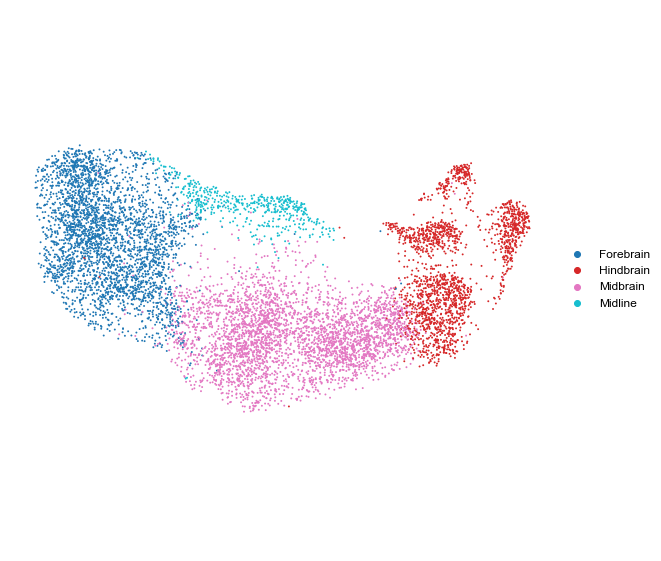

In [113]:
#This function creates a umap embedding with categorical annotations (e.g. cell type or cluster) and saves a copy of the figure to the same directory as the h5ad file

fig, ax = plt.subplots(1,1, figsize = (fig_size_fA, fig_size_fA))

sc.pl.embedding(
    adata, 
    color = [category_fA],
    palette = palette_fA,
    #legend_loc = 'on data',
    legend_fontsize = 'large',
    legend_fontoutline = 2,
    legend_fontweight = 'bold',
    ax = ax,
    size = dot_size_fA,
    show = False,
    edges = False,
    edges_width = 0.05,
    basis = rep_fA,
)
ax.set_title(title_fA)
format_ax(ax)
fig.savefig(f'{file_dir}/FigA.png', dpi = dpi, bbox_inches = 'tight', transparent = True) #Save path is same as h5ad folder path

## Figure Type B (Plot Multiple Categories, One on Each Embedding)

*Available categories can be found with the following code in the cell below. If a plot is taking too long, it is likely that the column you are attempting to plot is not categorical (e.g. something numerical, like a gene set score). In this case, you should stop execution of the cell and plot this column in Figure Type C.*

In [ ]:
# This shows all categories in the AnnData object
adata.obs.columns.tolist()

In [60]:
# This is the category you will plot below, from the adata.obs list above
category_fB = "Developmental Stage"

# Plotting parameters
fig_size_fB = 10
palette_fB = "tab10"
dot_size_fB = 15
rep_fB = 'X_umap' # options are 'X_umap'
ncols_fB = 3

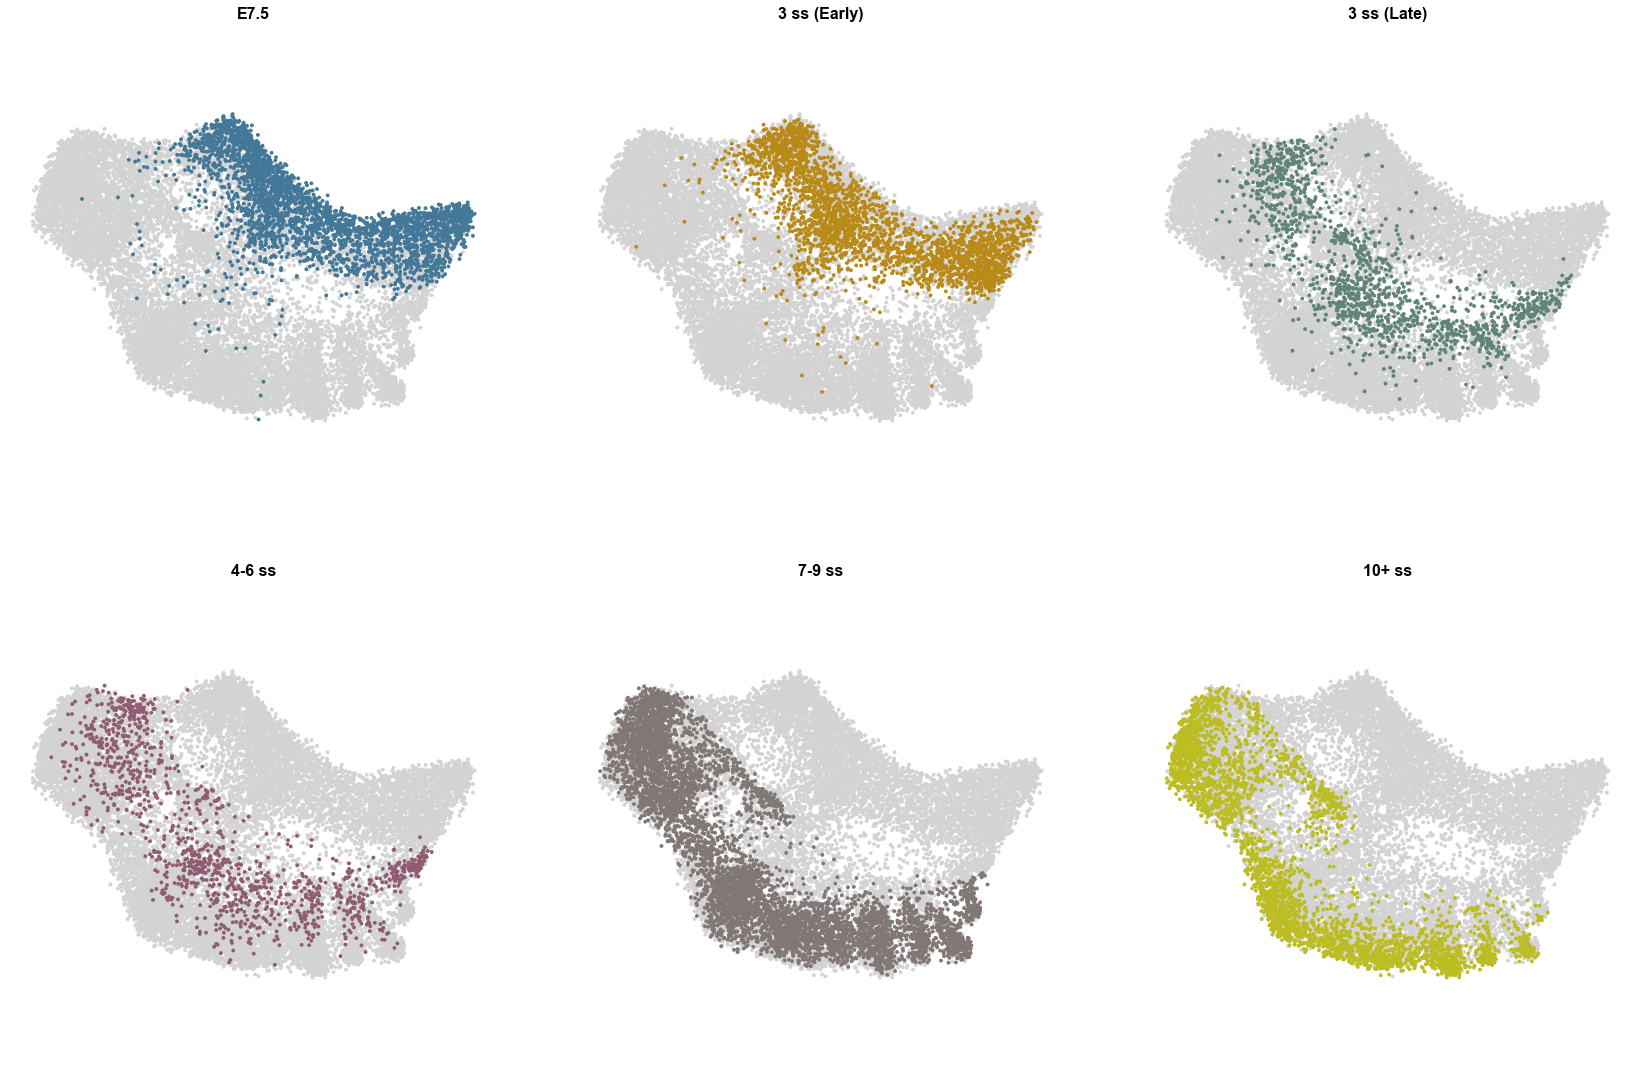

In [61]:
fig = plot_adata(
    adata,
    category_fB, 
    ncols = ncols_fB, 
    sorted = True,
    palette = palette_fB,
    rep = rep_fB,
    figsize = (fig_size_fB, fig_size_fB),
    s = dot_size_fB
)
fig.savefig(f'{file_dir}/FigB.png', dpi = dpi, bbox_inches = 'tight', transparent = True)

## Figure Type C (Plot Numerical Annotation on Single Embedding, e.g. raw or normalized gene expression)

In [30]:

annot_fC = "EN1" # This is symbol for the gene to plot (note all gene symbols are fully capitalized)

# Plotting parameters
fig_size_fC = 10
palette_fC = "viridis"
dot_size_fC = 20
rep_fC = 'X_umap' # options are 'X_umap'
title_fC = ""

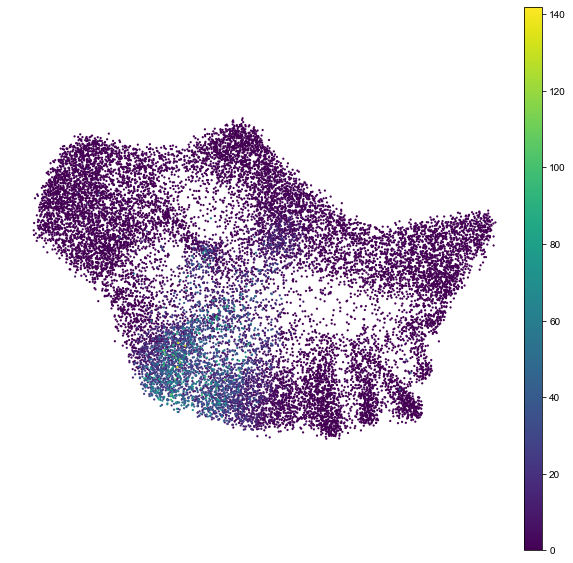

In [31]:
fig, ax = plt.subplots(1,1, figsize = (fig_size_fC, fig_size_fC))

sc.pl.embedding(
    adata, 
    color = [annot_fC],
    palette = palette_fC,
    ax = ax,
    size = dot_size_fC,
    show = False,
    edges = False,
    basis=rep_fC
)
ax.set_title(title_fC)
format_ax(ax)
fig.savefig(f'{file_dir}/FigC.png', dpi = dpi, bbox_inches = 'tight', transparent = True)

## Figure Type D (Plot Multiple Numerical Annotations in One Figure, e.g. gene expression)

In [32]:
# These are the genes you will plot below
annot_fD = [
    "OTX2", "EN1", 'GBX2'
]
# Titles must be in same order as genes above
titles_FD = [
    "OTX2", "EN1", 'GBX2'  
]

# Plotting parameters
fig_size_fD = 10
palette_fD = "viridis"
dot_size_fD = 15
rep_fD = 'X_umap' # options are 'X_umap'
ncols_fD = 3

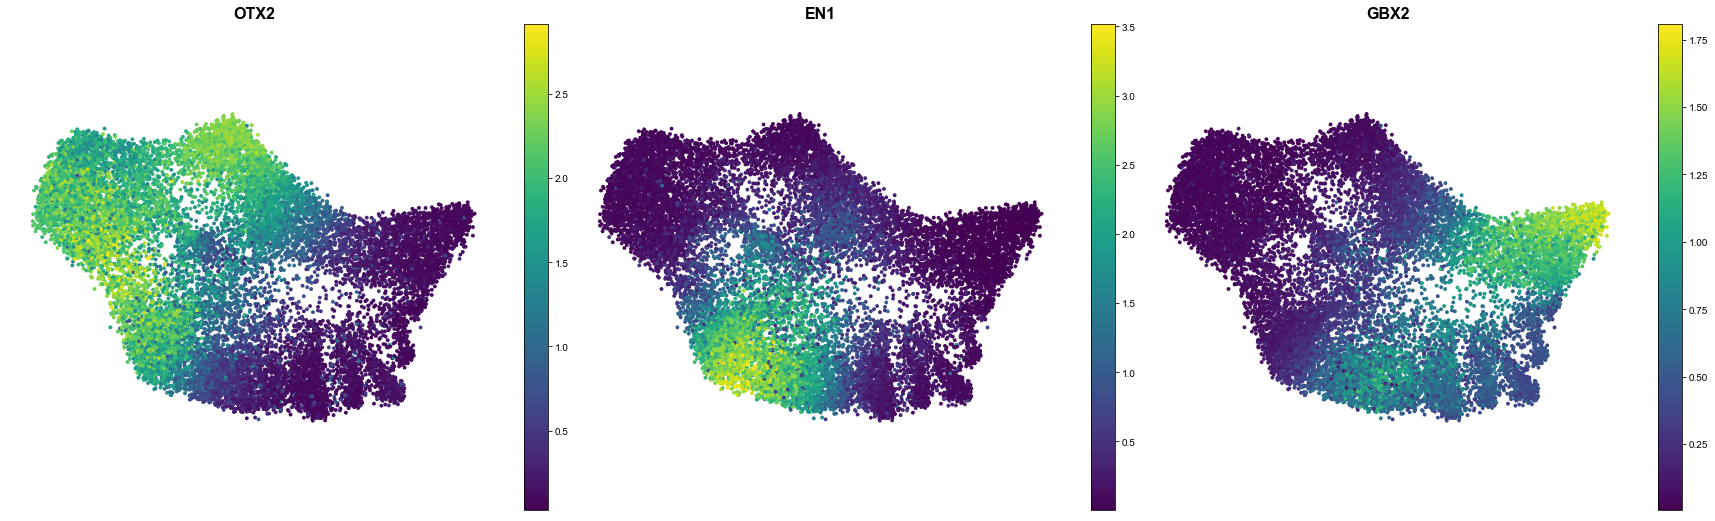

In [33]:
fig = plot_adata(
    adata,
    annot_fD,
    titles = titles_FD,
    ncols = ncols_fD, 
    sorted = False,
    palette = palette_fD,
    rep = rep_fD,
    figsize = (fig_size_fD, fig_size_fD),
    s = dot_size_fD,
    layer = 'imputed'
)
fig.savefig(f'{file_dir}/FigD.png', dpi = dpi, bbox_inches = 'tight', transparent = True)

## Figure Type E (Plot Multiple Genes with Specified Colors)

In [108]:
# One distribution will be plotted for each category
genes_fG = ["SIX3", "OTX2", "EN1", "GBX2", "HOXB2"]
# Must be in same order as genes
colors_fG = ["tab:blue", "tab:purple", "tab:green", "tab:orange", "tab:cyan"]

# Plotting parameters
fig_size_fG = 10
dot_size_fG = 15
rep_fG = 'X_umap'

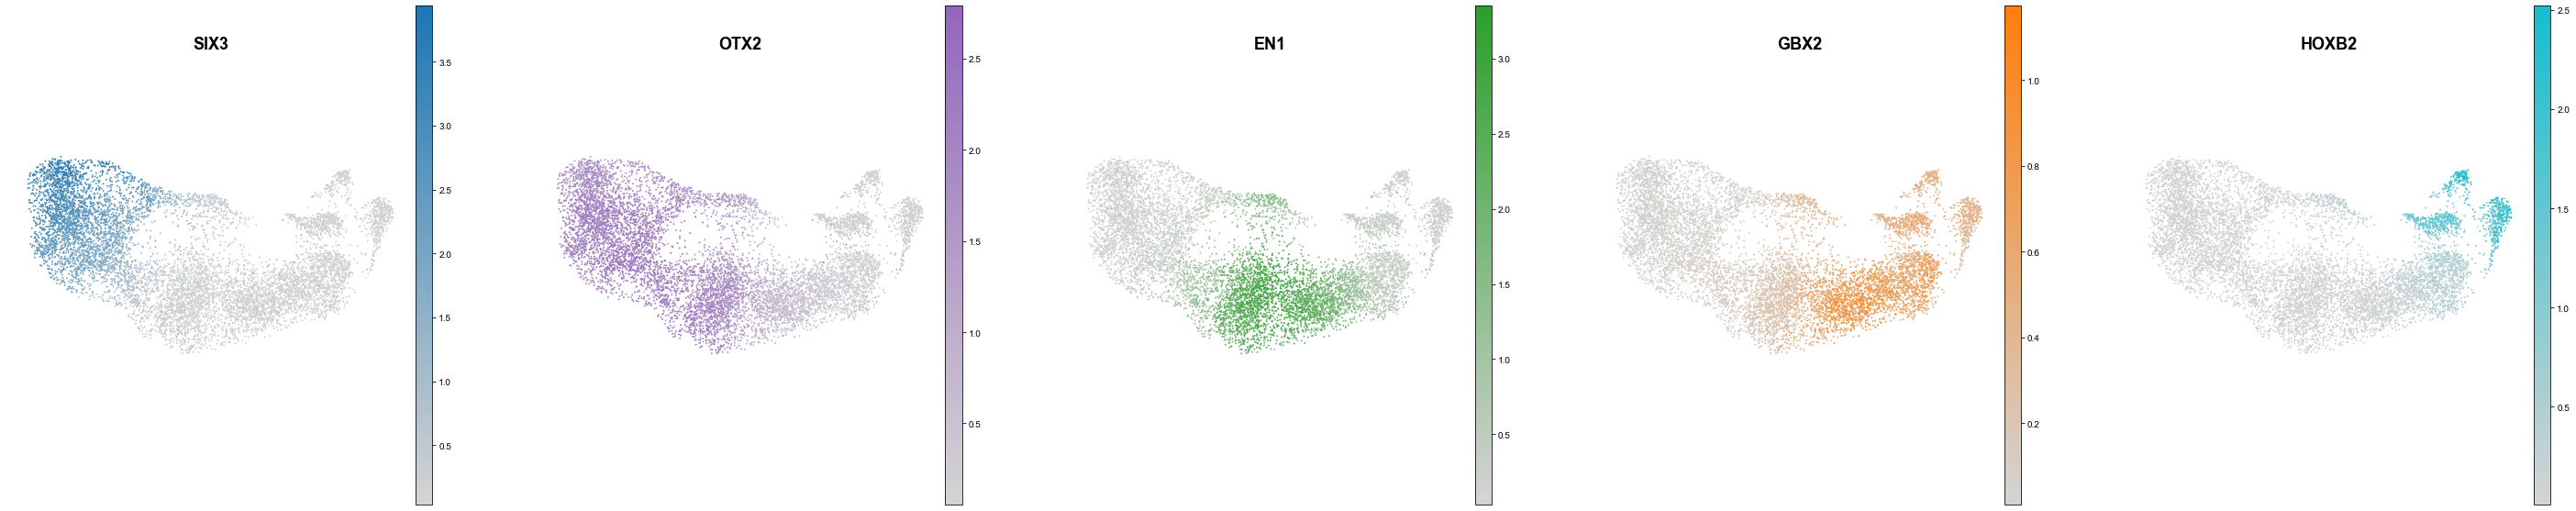

In [110]:
c = mcolors.ColorConverter().to_rgb
palettes = []
for color in colors_fG:
    palettes.append(make_colormap([c('lightgray'), 0.01, c('lightgray'), c(color), 0.99, c(color)]))

fig, axes = plt.subplots(1, len(genes_fG), figsize = (fig_size_fG*len(genes_fG), fig_size_fG))

for gene, ax, palette in zip(genes_fG, axes.flat, palettes):
    sc.pl.embedding(
        adata,
        basis = rep_fG,
        color = gene,
        cmap = palette,
        ax = ax,
        size = dot_size_fG,
        show = False,
        edges = False,
        sort_order = False,
        layer = 'imputed',
    )
    ax.set_title(gene, fontsize=18, fontweight='bold')
    format_ax(ax)
fig.savefig(f'{file_dir}/FigE.png', dpi = dpi, bbox_inches = 'tight', transparent = True)

## Figure Type F (Plot heatmaps of gene expression ordered by numerical annotation, e.g. a diffusion component)

In [ ]:
# Remove relevant neural plate regions using the below codes, simply add a # in front of those you want to keep for analysis
region = "Midline"
adata = adata[adata.obs['Neural Plate Annotation'] != region].copy()

#region = "Forebrain"
#adata = adata[adata.obs['Neural Plate Annotation'] != region].copy()

#region = "Midbrain"
#adata = adata[adata.obs['Neural Plate Annotation'] != region].copy()

#region = "Hindbrain"
#adata = adata[adata.obs['Neural Plate Annotation'] != region].copy()

In [31]:
# These are the genes whose expression will be plotted in each row, on 0-1 scale
genes_fF = ['SIX3', 'OTX2', 'EN1', 'GBX2', 'HOXB2']
# This is the x-axis variable below; must be in adata.obs
annot_fF = "DC 0"
# This is the top row along the x-axis below; must be in adata.obs
category_fF = "Neural Plate Annotation"

# Plotting parameters
fig_size_x_fF = 12
fig_size_y_fF = 6
fontsize_fF = 14
palette_fF = "viridis"
categorical_palette_fF = "Set2"

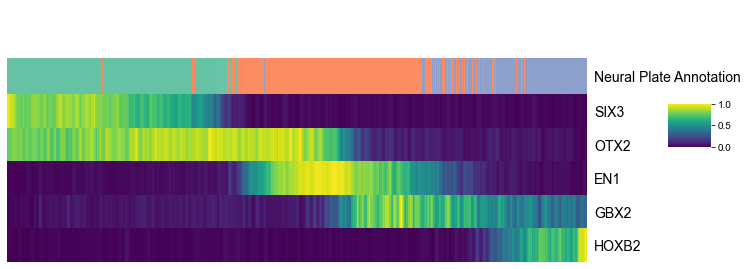

In [32]:
df = pd.DataFrame(adata.obs[annot_fF])
for gene in genes_fF:
    df[gene] = adata[:, gene].layers['log']
    
sort_idx = df.sort_values(annot_fF).index
df = df.loc[sort_idx]
df = df.rolling(50, min_periods = 50, axis = 0).mean()

col_colors = pd.factorize(adata.obs.loc[sort_idx, category_fF])[0]
col_cmap = sns.color_palette(categorical_palette_fF, np.unique(col_colors).shape[0])
df[category_fF] = [col_cmap[c] for c in col_colors]

df = df.dropna()

cm = sns.clustermap(
    df[genes_fF].T,
    standard_scale = 0,
    col_cluster = False,
    row_cluster = False,
    cmap = palette_fF,
    figsize = (
        fig_size_x_fF,
        fig_size_y_fF,
    ),
    col_colors = df[category_fF],
    colors_ratio = 1./(df.shape[1]),
    cbar_pos = (0.95,0.65,0.05,0.1)
)
#cm.cax.remove()  # remove colorbar
cm.ax_row_dendrogram.set_visible(False)
cm.ax_heatmap.tick_params(axis='x', which = "both", bottom = False, labelbottom = False)
cm.ax_heatmap.tick_params(axis='y', which = "both", right = False, labelsize = fontsize_fF, rotation = 0)
cm.ax_heatmap.tick_params(axis='y', which = "both", right = False, labelsize = fontsize_fF, rotation = 0)
cm.ax_col_colors.tick_params(axis='y', which = "both", right = False, labelsize = fontsize_fF, rotation = 0)
fig.savefig(f'{file_dir}/FigF.png', dpi = dpi, bbox_inches = 'tight', transparent = True)

## Figure Type G (Line plots of normalized gene expression ordered by a numerical annotation)

In [92]:
# These are the genes whose expression will be plotted below
genes_fH = ['SIX3', 'OTX2', 'EN1', 'WNT1', 'FGF8', 'GBX2', 'HOXB2']
# This is the x-axis variable below; must be in adata.obs
annot_fH = "DC 1"

# Plotting parameters
palette_fH = "tab10"
x_label_fH = "Normalized DC 0 (A-P Axis)"
y_label_fH = "Normalized Gene Expression"

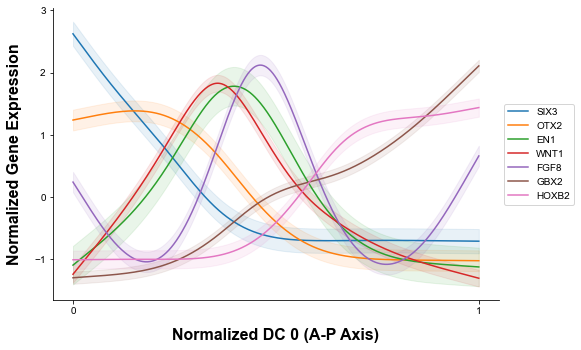

In [93]:
with HiddenPrints():
    # Compute gene trends for all highly variable genes
    trends, std = compute_gene_trends(
        adata, 
        genes = genes_fH,
        trajectory = annot_fH,
        imputed_layer = 'imputed',
    )

fig, ax = plot_gene_trends(trends, std, genes_fH, palette_fH, norm=True)
ax.set_xlabel(x_label_fH, fontsize = 16, fontweight = 'bold', labelpad = 12)
ax.set_ylabel(y_label_fH, fontsize = 16, fontweight = 'bold', labelpad = 12)
fig.savefig(f'{file_dir}/FigG.png', dpi = dpi, bbox_inches = 'tight', transparent = True)

## Figure Type H (Violin plots of numerical annotation by cell plotted against a categorical annotation)

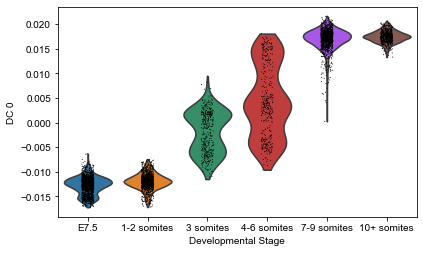

In [33]:
sc.pl.violin(adata, keys='DC 0', groupby='Developmental Stage', save= 'FigH.png') #The example figure was generated from the FVB_Hindbrain.h5ad dataset

## Figure Type I (Dot plots of gene expression by categorical annotation)

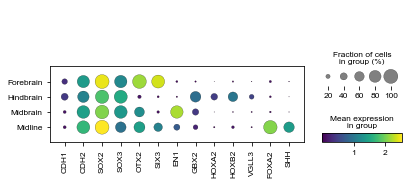

In [25]:
genes_for_fig = ['CDH1', 'CDH2', 'SOX2', 'SOX3', 'OTX2', 'SIX3', 'EN1', 'GBX2', 'HOXA2', 'HOXB2', 'VGLL3', 'FOXA2', 'SHH']
sc.pl.dotplot(adata, genes_for_fig, groupby='Neural Plate Annotation', use_raw=False, cmap='viridis', save='FigI.png') #The example figure was generated from the FVB_Neural_Plate.h5ad dataset